# 2.2 Analyses of combined states - state statistics

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [3]:

""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
from collections import defaultdict
import pandas as pd
import pickle

from one.api import ONE
from pprint import pprint
import matplotlib.pyplot as plt
from scipy.stats import mode

# --Machine learning and statistics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance_matrix, distance

# Get my functions
functions_path = prefix + 'representation_learning_variability//Models/Sub-trial/2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =   prefix + 'representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import transition_probabilities, trans_mat_complete
from plotting_functions import create_grouped_gradient_palette
functions_path =   prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
one = ONE(mode='remote')

## Parameters

In [9]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0
optimal_k = 4

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


identifiable_mapping = {'000': 0.0,
           '100': 1.0,
           '200': 2.0,
           '300': 3.0,
           '010': 4.0,
           '110': 5.0,
           '210': 6.0,
           '310': 7.0,
           '001': 8.0,
           '101': 9.0,
           '201': 10.0,
           '301': 11.0, 
           '011': 12.0,
           '111': 13.0,
           '211': 14.0,
           '311': 15.0,
           'nan': np.nan
           }
inverted_mapping = {v: k for k, v in identifiable_mapping.items()}

# Individual sessions

In [5]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Statistics per state

In [6]:
# Load preprocessed data
results_path = prefix + 'representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_states = str(results_path + 'states_trial_type03-11-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')

## Unique states use

In [14]:
unique_states = states_file[['mouse_name', 'session', 'identifiable_states']].drop_duplicates()

In [45]:
unique_states_count = pd.DataFrame(unique_states.groupby(['identifiable_states', 'session'])['identifiable_states'].count())
unique_states_count = unique_states_count.rename(columns={"identifiable_states": "count"}).reset_index()
unique_states_count = pd.DataFrame(unique_states_count.groupby(['identifiable_states'])['count'].sum()).reset_index()
unique_states_count['ratio'] = unique_states_count['count'] / len(states_file['session'].unique())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Syllables')

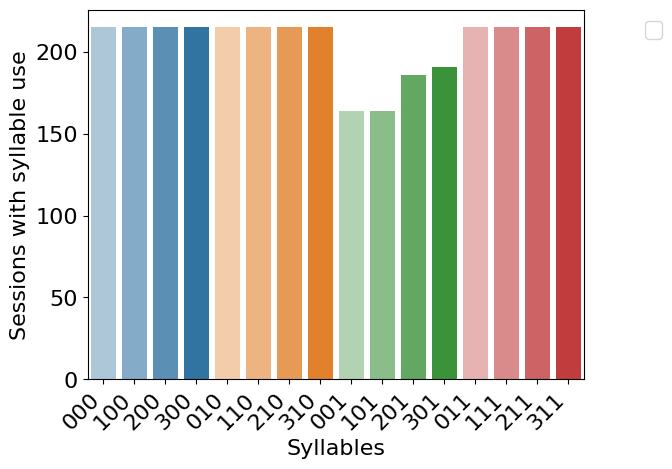

In [48]:
palette_16 = create_grouped_gradient_palette(n_groups=4, shades_per_group=4, base_palette='tab10')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
order = ['000', '100', '200', '300', '010', '110',
           '210', '310', '001', '101', '201', '301', '011',
           '111', '211', '311']
state_to_color = dict(zip(order, palette_16_list))
# plt.figure(figsize=[8, 8])
plt.rc('font', size=16)

sns.barplot(x='identifiable_states', y='count', data=unique_states_count, order=order, palette=state_to_color)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.ylabel('Sessions with syllable use')
plt.xlabel('Syllables')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Syllables')

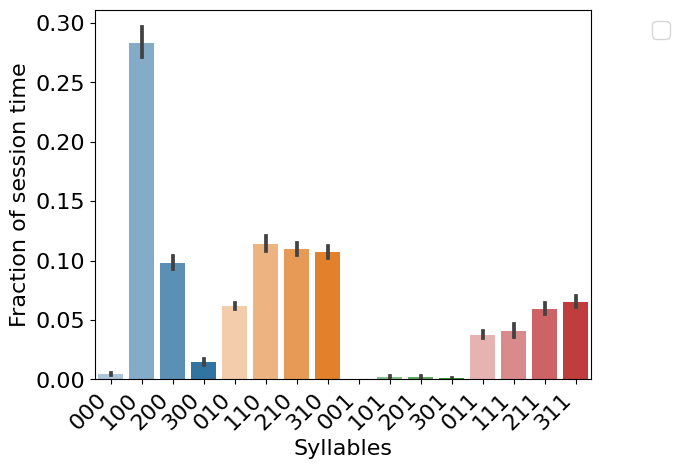

In [61]:
fractions = states_file.groupby(['session'])['identifiable_states'].value_counts(normalize=True).rename('fraction').reset_index()
order = ['000', '100', '200', '300', '010', '110',
           '210', '310', '001', '101', '201', '301', '011',
           '111', '211', '311']
state_to_color = dict(zip(order, palette_16_list))
# plt.figure(figsize=[8, 8])
plt.rc('font', size=16)

sns.barplot(x='identifiable_states', y='fraction',  data=fractions, order=order, palette=state_to_color)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.ylabel('Fraction of session time')
plt.xlabel('Syllables')

Text(0.5, 0, 'Syllables')

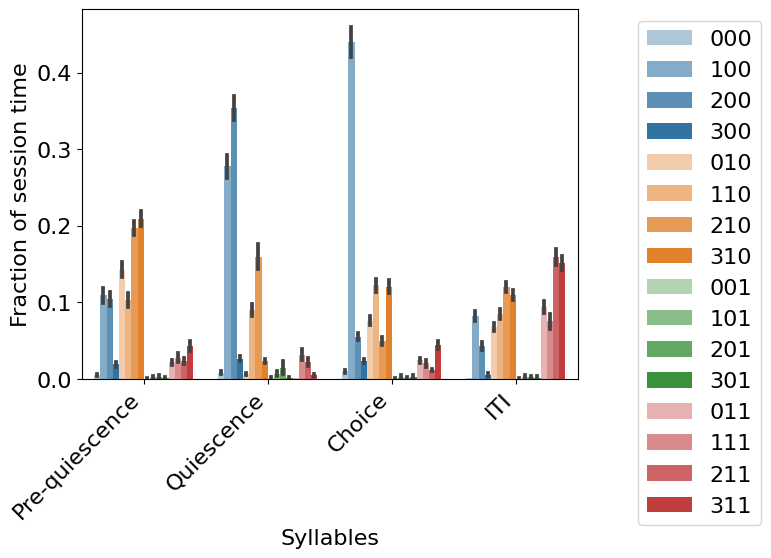

In [59]:
fractions = states_file.groupby(['session', 'broader_label'])['identifiable_states'].value_counts(normalize=True).rename('fraction').reset_index()

order = ['000', '100', '200', '300', '010', '110',
           '210', '310', '001', '101', '201', '301', '011',
           '111', '211', '311']
state_to_color = dict(zip(order, palette_16_list))
# plt.figure(figsize=[8, 8])
plt.rc('font', size=16)

sns.barplot(hue='identifiable_states', y='fraction', x='broader_label', data=fractions, order=['Pre-quiescence',
                                                                                               'Quiescence', 'Choice', 'ITI'],hue_order=order, palette=state_to_color)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.ylabel('Fraction of session time')
plt.xlabel('Syllables')

## State dwell time and transition matrix

In [37]:
palette_16 = create_grouped_gradient_palette(n_groups=4, shades_per_group=4, base_palette='tab10')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
order = ['000', '100', '200', '300', '010', '110',
           '210', '310', '001', '101', '201', '301', '011',
           '111', '211', '311']
state_to_color = dict(zip(order, palette_16_list))

In [82]:
group_state_freq = pd.DataFrame(columns=['mouse_name', 'session', 'identifiable_states', 'median_duration', 'mean_duration', 'trans_mat'])
group_trans_mat = pd.DataFrame(columns=['mouse_name', 'session', 'trans_mat'], index=range(len(idxs)))

for m, mat in enumerate(idxs):

    mouse_name = mat[37:]
    session = mat[0:36]
    session_states = states_file.loc[states_file['session']==session]

    new_states = np.array(session_states['most_likely_states'])
    num_states = len(np.unique(new_states))
    all_identifiable_states = np.array(list(identifiable_mapping.keys()))[:-1]
            
    """ State statistics """
    state_freq = pd.DataFrame(columns=['mouse_name', 'session', 'identifiable_states',
                                        'median_duration', 'mean_duration'], index=range(len(all_identifiable_states))) 
    
    state_freq['mouse_name'] = mouse_name
    state_freq['session'] = session
    state_freq['identifiable_states'] = all_identifiable_states
            
    # State for which we have the durations
    dif = np.diff(new_states)
    jump = np.where(dif != 0)
    jump_dif = np.diff(jump)
    median = np.nanmedian(jump_dif)

    state_names = new_states[jump][1:]
    unique_states = np.array(list(inverted_mapping.keys()))
    unique_states = unique_states[~np.isnan(unique_states)]
    replace_func = np.vectorize(inverted_mapping.get)
    state_label = replace_func(unique_states)

    for s, st in enumerate(unique_states):
        state_durations = jump_dif[0][np.where(state_names==st)]
        state_freq.loc[state_freq['identifiable_states']==state_label[s], 'median_duration'] = np.median(state_durations*bin_size)
        state_freq.loc[state_freq['identifiable_states']==state_label[s], 'mean_duration'] = np.mean(state_durations*bin_size)
    
    # sns.barplot(x='identifiable_states', y='median_duration', data=state_freq, order=state_label, palette=state_to_color)
    # plt.xticks(rotation=45, ha='right')
    # plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
    # plt.ylabel('Median dwell time (s)')
    # plt.xlabel('Syllables')
    # plt.show()

    # Save to big df
    if len(group_state_freq) == 0:
        group_state_freq = state_freq.copy()
    else:
        group_state_freq = group_state_freq.append(state_freq)
                        
    """ State transition matrix (empirical) """
    transition_matrix = transition_probabilities(new_states, unique_states)
    # plt.imshow(transition_matrix)
    # plt.xlabel('Current state')
    # plt.ylabel('Previous state')
    # plt.xticks(np.arange(0, num_states), state_label)
    # plt.yticks(np.arange(0, num_states), state_label)
    # plt.xticks(rotation=45, ha='right')
    # plt.show()
    group_trans_mat['mouse_name'][m] = mouse_name
    group_trans_mat['session'][m] = session
    # group_trans_mat['trans_mat'][m] = trans_mat_complete(identifiable_mapping, state_label, unique_states, transition_matrix)
    group_trans_mat['trans_mat'][m] = transition_matrix

/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_76060/1596132938.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group_state_freq = group_state_freq.append(state_freq)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/nt/d2j3zp9d1xzb8wgfrw81j0c40000gn/T/ipykernel_76060/1596132938.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  group_state_freq = group_state_freq.append(state_freq)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWar

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


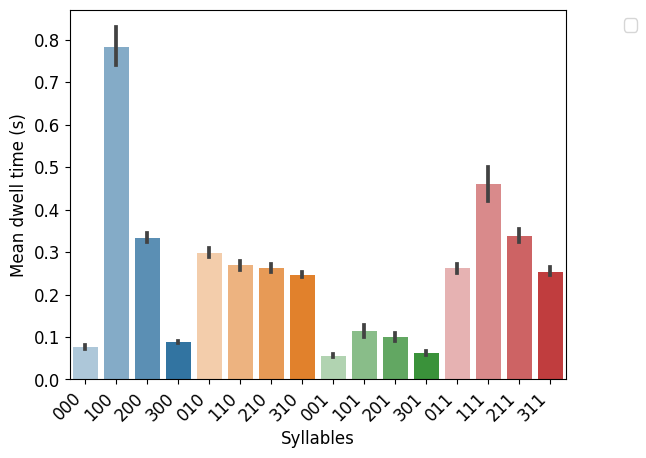

In [84]:
sns.barplot(x='identifiable_states', y='mean_duration', data=group_state_freq, order=state_label, palette=state_to_color)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.ylabel('Mean dwell time (s)')
plt.xlabel('Syllables')
plt.show()

Text(46.722222222222214, 0.5, 'Previous state')

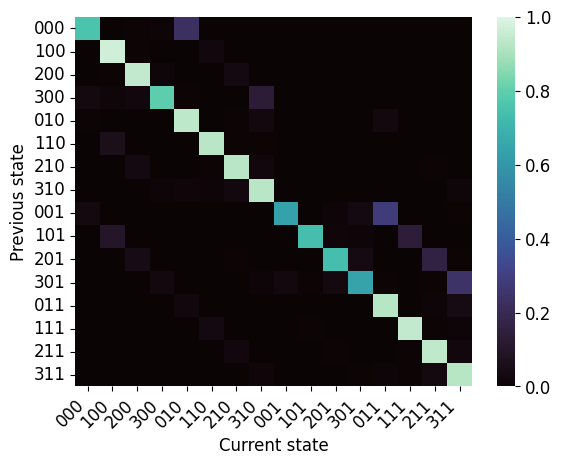

In [86]:
# Results on original model
plt.rc('font', size=12) 
# plt.figure(figsize=[9, 8])
hmap = sns.color_palette("mako", as_cmap=True)
stacked_matrices = np.stack(group_trans_mat['trans_mat'].dropna().values)
nanmean_matrix = np.nanmean(stacked_matrices, axis=0)
sns.heatmap(nanmean_matrix, annot=False, fmt='.1f',
    yticklabels=order, xticklabels=order, 
    cmap= hmap, vmin=0, vmax=1) 
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.xlabel('Current state')
plt.ylabel('Previous state')


## Empirical state average

In [8]:

whisker_mapping = {0:'0', 1:'0', 2:'0', 3:'0',
                 4:'0', 5:'0', 6:'0', 7:'0',
                 8:'1', 9:'1', 10:'1', 11:'1',
                 12:'1', 13:'1', 14:'1', 15:'1'}

replace_whisker = np.vectorize(whisker_mapping.get)
states_file['most_likely_states'] = replace_whisker(states_file['most_likely_states'])
states_file = states_file.rename(columns={"variable": "Frequency"})
states_file = states_file.rename(columns={"most_likely_states": "Licking"})

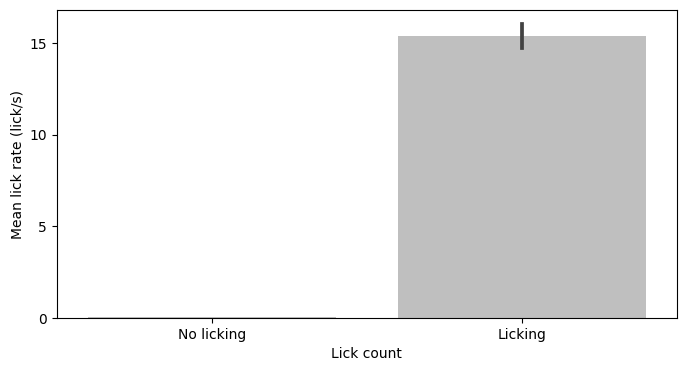

In [9]:
plt.figure(figsize=(8, 4))
# colors = sns.color_palette("viridis", 4)
grouped_df = pd.DataFrame(states_file.groupby(['session', 'Licking'])['Lick count'].mean()).reset_index()
grouped_df['Lick count'] = grouped_df['Lick count'] *60
sns.barplot(x='Licking', y='Lick count', data=grouped_df, color='grey',alpha=0.5)
plt.xlabel('Lick count')
plt.xticks([0, 1], ['No licking', 'Licking'])
plt.ylabel('Mean lick rate (lick/s)')


plt.rcParams.update({'font.size': 16})
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))